In [1]:
import pandas as pd
import numpy as np
from future.utils.surrogateescape import encoded

from Models.DT import *
from utils.utils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from Models.AutoEncoder import AutoEncoder, AE_trainDataset, AE_validDataset, AE_Dataset
from utils.utils import *
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
df = pd.read_csv("Data/[24-2 DS_Project2] Data.csv")

In [4]:
batch_size = 128
encoding_dim = 27
lr = 1e-4
l1_lambda = 1e-6

In [5]:
cat_features = ['Card', 'Gender', 'Card Brand', 'Card Type', 'Expires', 'Has Chip', 
                'Year PIN last Changed', 'Whether Security Chip is Used', 'Day']
num_features = ['Current Age', 'Retirement Age', 'Per Capita Income - Zipcode',
                'Yearly Income', 'Total Debt', 'Credit Score', 'Credit Limit', 'Amount', 'Since Open Month']
discarded = ['User', 'Birth Year', 'Birth Month']

In [6]:
data_path = 'Data/[24-2 DS_Project2] Data.csv'

In [7]:
(train_cat_X, train_num_X, train_y), (valid_cat_X, valid_num_X, valid_y), label_encoders = dt_process_data(
    data_path,
    cat_features,
    num_features,
    discarded
)

TRANSITION
IQR
SPLIT
DISCARD
SCALE
ENCODE
TARGET
TRAIN CAT/NUM
VALID CAT/NUM
RETURN


In [8]:
smote = SMOTE(random_state=42, sampling_strategy=0.5)
train_X_resampled, train_y_resampled = smote.fit_resample(
    pd.concat([train_cat_X, train_num_X], axis=1), train_y['Is Fraud?']
)
# Resampled 데이터를 나누기
train_cat_X_resampled = train_X_resampled[cat_features]
train_num_X_resampled = train_X_resampled[num_features]
train_y_resampled = pd.DataFrame(train_y_resampled, columns=['Is Fraud?'])

In [9]:
print("Before SMOTE:", train_y['Is Fraud?'].value_counts())
print("After SMOTE:", train_y_resampled['Is Fraud?'].value_counts())


Before SMOTE: Is Fraud?
0.0    896343
1.0      1130
Name: count, dtype: int64
After SMOTE: Is Fraud?
0.0    896343
1.0    448171
Name: count, dtype: int64


In [10]:
train_dataset = AE_Dataset(train_cat_X_resampled, train_num_X_resampled, train_y_resampled, device)
valid_dataset = AE_Dataset(valid_cat_X, valid_num_X, valid_y, device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [11]:
model = AutoEncoder(encoding_dim=encoding_dim, cat_features=cat_features, num_features=num_features).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.MSELoss()

In [12]:
checkpoint = torch.load('experiments/AutoEncoder/best_model.pth')
model.load_state_dict(checkpoint)

/tmp/ipykernel_102103/4157255290.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('experiments/AutoEncoder/best_model.pth')


<All keys matched successfully>

In [13]:
model.eval()

AutoEncoder(
  (cat_embeddings): ModuleList(
    (0-8): 9 x Embedding(100, 5)
  )
  (fc_cat): Linear(in_features=54, out_features=64, bias=True)
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=27, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=27, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=48, out_features=18, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [14]:
train_embeddings = model.get_embedding(
    torch.tensor(train_cat_X_resampled.values, dtype=torch.long).to(device),
    torch.tensor(train_num_X_resampled.values, dtype=torch.float).to(device),
)

train_embeddings = train_embeddings.cpu().detach().numpy()

[[0.48021892 1.411359   0.3284338  2.1202567  1.3658061  1.8410677
  0.7175019  0.5545119  1.5335969  1.0843831  0.8837944  0.9132262
  1.6844661  1.0942904  2.2207317  1.6992459  1.0550147  1.4058197
  1.9167818  1.386858   1.4805058  0.9765566  1.7524307  0.72506243
  0.85437185 1.5430262  1.6086159 ]]


In [15]:
valid_embeddings = model.get_embedding(
    torch.tensor(valid_cat_X.values, dtype=torch.long).to(device),
    torch.tensor(valid_num_X.values, dtype=torch.float).to(device),
)

valid_embeddings = valid_embeddings.cpu().detach().numpy()

In [16]:
rf_classifier = RandomForestClassifier(random_state=42,
                                       max_depth=10,
                                       min_samples_leaf=3,
                                       class_weight={0: 1, 1: 10})

In [17]:
rf_classifier.fit(train_embeddings, train_y_resampled)

/home/hyun/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=10,
                       min_samples_leaf=3, random_state=42)

In [22]:
y_pred = rf_classifier.predict(valid_embeddings)

In [23]:
conf_matrix = confusion_matrix(valid_y, y_pred)

In [24]:
# 혼동 행렬 출력
print("Confusion Matrix:")
print(conf_matrix)

# F1 score 계산 및 출력
f1 = f1_score(valid_y, y_pred)
print("\nF1 Score:", f1)

Confusion Matrix:
[[120921 185234]
 [   183    301]]

F1 Score: 0.0032362285572979104


Text(70.72222222222221, 0.5, 'y')

/home/hyun/anaconda3/envs/ai/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/hyun/anaconda3/envs/ai/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/hyun/anaconda3/envs/ai/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/hyun/anaconda3/envs/ai/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 47148 (\N{HANGUL SYLLABLE RYEOL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/hyun/anaconda3/envs/ai/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/h

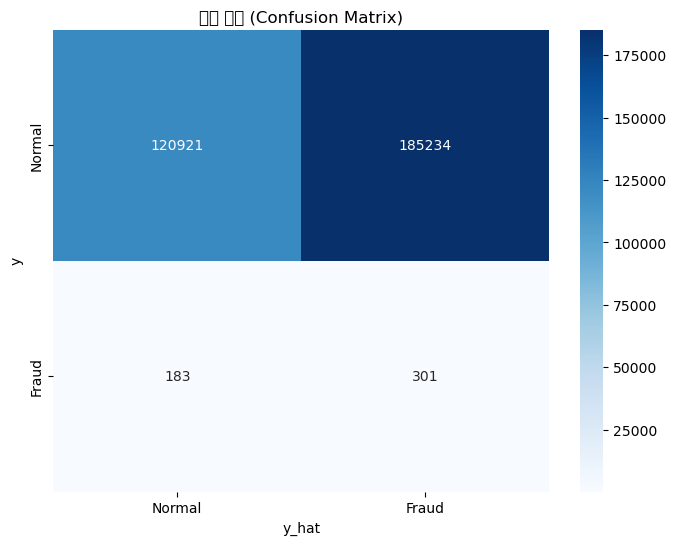

In [25]:
# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d',
            cmap='Blues',
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.title('혼동 행렬 (Confusion Matrix)')
plt.xlabel('y_hat')
plt.ylabel('y')